<a href="https://colab.research.google.com/github/akshaya-nagarajan/DeepLearningProjects/blob/master/Assignment_2/DLAssignment2_MultiClass_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mouting the Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'DeepLearningProjects/fastai/food-101/images'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


## Importing the Libraries

In [0]:
from __future__ import absolute_import, division, print_function

import tensorflow
import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input, BatchNormalization, Multiply, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import RMSprop, SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input
#from keras.utils.np_utils import to_categorical
from keras.utils import plot_model

from sklearn.metrics import accuracy_score, confusion_matrix

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

## Check TF version and whether GPU is enabled

In [0]:
print(tf.__version__)
print(tf.test.gpu_device_name())

2.2.0



## Downloading the Food dataset

In [0]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [0]:
get_data_extract()

4996284416/4996278331 [==============================] - 450s 0us/step
Dataset downloaded and extracted!


## Listing the files in the directory

In [0]:
os.listdir()

['.config', 'gdrive', 'food-101.tar.gz', 'food-101', 'sample_data']

In [0]:
# Check the extracted dataset folder
os.listdir('food-101/')

['license_agreement.txt', 'meta', 'images', 'README.txt']

In [0]:
os.listdir('food-101/meta')

['test.json',
 'train.json',
 'labels.txt',
 'classes.txt',
 'test.txt',
 'train.txt']

## Displaying Sample Images

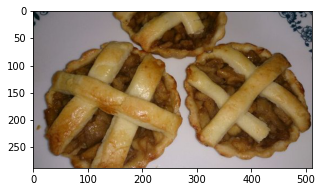

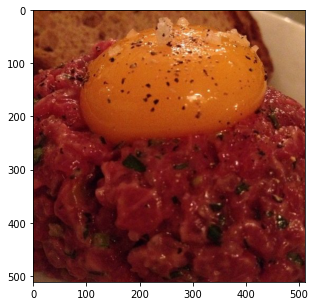

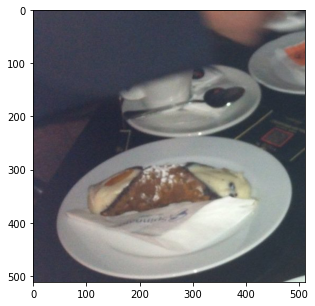

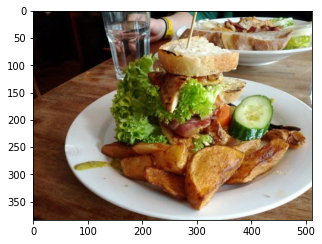

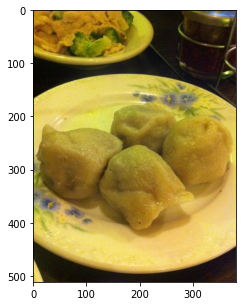

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))
img = plt.imread('food-101/images/apple_pie/3420738.jpg')
plt.imshow(img)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
img = plt.imread('food-101/images/beef_tartare/2625480.jpg')
plt.imshow(img)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
img = plt.imread('food-101/images/cannoli/1548541.jpg')
plt.imshow(img)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
img = plt.imread('food-101/images/club_sandwich/1451809.jpg')
plt.imshow(img)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
img = plt.imread('food-101/images/dumplings/277557.jpg')
plt.imshow(img)

# Split dataset into train and test folders

In [0]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

## Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt

In [0]:
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

## Prepare test data by copying images from food-101/images to food-101/test using the file test.txt

In [0]:
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [0]:
train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [0]:
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


## Helper method to create train_mini and test_mini data samples

In [0]:
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

## Picking 3 food items and generating separate data folders for the same

In [0]:
food_list = ['cannoli','pizza','omelette']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [0]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into cannoli
Copying images into pizza
Copying images into omelette


In [0]:
print("Total number of samples in train folder")
train_files = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
print(train_files)

Total number of samples in train folder
2250


In [0]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into cannoli
Copying images into pizza
Copying images into omelette


In [0]:
print("Total number of samples in test folder")
test_files = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])
print(test_files)

Total number of samples in test folder
750


In [0]:
img_width, img_height = 299, 299
train_data_dir = 'food-101/train_mini'
validation_data_dir = 'food-101/test_mini'
batch_size = 64

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(train_data_dir, target_size=(img_height, img_width), batch_size=batch_size, class_mode='categorical')
validation_generator = test_datagen.flow_from_directory(validation_data_dir, target_size=(img_height, img_width), batch_size=batch_size,class_mode='categorical')

model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu', input_shape = (224,224,3), kernel_initializer='he_normal'))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = 2, padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 128, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu',kernel_initializer='he_normal'))
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation = "relu",kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax",kernel_initializer='he_normal',kernel_regularizer=l2()))

#callbacks
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True, save_weights_only=True)
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, mode='auto')
reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, mode='auto')

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [0]:
model.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 112, 112, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0

In [0]:
history = model.fit_generator(train_generator, steps_per_epoch=2250/64, validation_data=validation_generator, validation_steps=750/64, epochs=10, callbacks=[checkpointer, reduceLR, earlystopping])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
36/35 [==============================] - ETA: -4s - loss: 1.2536 - accuracy: 0.3631
Epoch 00001: val_loss improved from inf to 1.07691, saving model to model.hdf5
36/35 [==============================] - 203s 6s/step - loss: 1.2536 - accuracy: 0.3631 - val_loss: 1.0769 - val_accuracy: 0.4867 - lr: 0.0010
Epoch 2/10
36/35 [==============================] - ETA: -4s - loss: 1.0215 - accuracy: 0.5142
Epoch 00002: val_loss improved from 1.07691 to 0.99317, saving model to model.hdf5
36/35 [==============================] - 201s 6s/step - loss: 1.0215 - accuracy: 0.5142 - val_loss: 0.9932 - val_accuracy: 0.6040 - lr: 0.0010
Epoch 3/10
36/35 [==============================] - ETA: -4s - loss: 0.9682 - accuracy: 0.5582
Epoch 00003: val_loss improved from 0.99317 to 0.90994, saving model to model.hdf5
36/35 [==============================] - 201s 6s/step - loss: 0.9682 - accuracy: 0.5582 - val_loss: 0.9099 -

In [0]:
history.history

{'accuracy': [0.36311110854148865,
  0.5142222046852112,
  0.558222234249115,
  0.5960000157356262,
  0.6302222013473511,
  0.6733333468437195,
  0.6840000152587891,
  0.7057777643203735,
  0.7319999933242798,
  0.7435555458068848],
 'loss': [1.253576636314392,
  1.0214985609054565,
  0.9681733846664429,
  0.9190927743911743,
  0.8772143125534058,
  0.8321845531463623,
  0.8055045008659363,
  0.7605641484260559,
  0.7106232047080994,
  0.694151759147644],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001],
 'val_accuracy': [0.4866666793823242,
  0.6039999723434448,
  0.5960000157356262,
  0.5373333096504211,
  0.6666666865348816,
  0.7146666646003723,
  0.6959999799728394,
  0.7293333411216736,
  0.7360000014305115,
  0.7400000095367432],
 'val_loss': [1.0769068002700806,
  0.9931709170341492,
  0.9099405407905579,
  0.941800594329834,
  0.8470644354820251,
  0.7900049090385437,
  0.760754406452179,
  0.7167609333992004,
  0.6596542596817017,
  0.704956233501

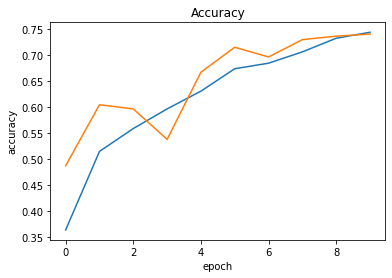

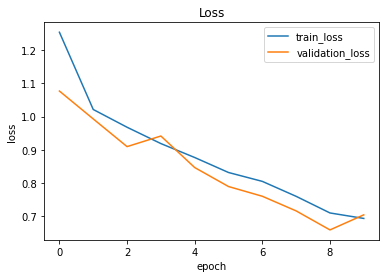

In [0]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy']) 
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history, 'Accuracy')
plot_loss(history, 'Loss')